<a href="https://colab.research.google.com/github/Blurr99/tensorflow_deepLearning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up

Scaling up the previously built model to encompass of classes of Food101 dataset (101 classes of food).

Goal is to beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

In [ ]:
# Checking the gpu
!nvidia-smi

Wed Jan 17 04:21:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Helper function
Downloading the previously build script that contains a lot of helpful helper functions.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-17 08:26:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-17 08:26:11 (63.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions into this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101Food Classes

Goal is to beat the original Food101 paper with 10% of the training data. So downloading it...

The data being used in this notebook comes from the original Food101 dataset but has been preprocessed.


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2024-01-17 08:26:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 74.125.199.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  96.0MB/s    in 19s     

2024-01-17 08:26:36 (80.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [ ]:
# Checking the number of images and directories in the dataset
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/oysters'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/paella'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training a model for 101 classes with 10% of the data
Steps:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to incorporate data augmentation into the model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model.
* Compile the model
* Feature extract for 5 full passes (5 epochs for the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Creata ModelCheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = "val_accuracy",
                                                         save_best_only = True)

In [ ]:
# Create a data augmentation layer to incorporate data augmentation into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images to between 0 & 1. Required for models like ResNet50
], name = "data_augmentation")

In [ ]:
len(train_data_all_10_percent.class_names)

101

In [ ]:
# Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name = "input_layer")
x = data_augmentation(inputs) # Augment images (only happens in training phase)
x = base_model(x, training = False) #Put the base model in inference mode so weights which need to stay frozen stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Summary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_avg_pooling (Global  (None, 1280)              0         
 AveragePooling2D)                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Compiling the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fitting the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15 * len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 160s 628ms/step - loss: 3.3614 - accuracy: 0.2717 - val_loss: 2.5159 - val_accuracy: 0.4370
Epoch 2/5
237/237 [==============================] - 111s 465ms/step - loss: 2.1948 - accuracy: 0.4958 - val_loss: 2.0737 - val_accuracy: 0.4942
Epoch 3/5
237/237 [==============================] - 95s 398ms/step - loss: 1.8178 - accuracy: 0.5678 - val_loss: 1.9051 - val_accuracy: 0.5183
Epoch 4/5
237/237 [==============================] - 83s 349ms/step - loss: 1.6104 - accuracy: 0.6098 - val_loss: 1.8328 - val_accuracy: 0.5384
Epoch 5/5
237/237 [==============================] - 73s 307ms/step - loss: 1.4621 - accuracy: 0.6434 - val_loss: 1.8070 - val_accuracy: 0.5334


In [ ]:
# Evaluate on the entire dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 72ms/step - loss: 1.5711 - accuracy: 0.5869


[1.5710935592651367, 0.5868911147117615]

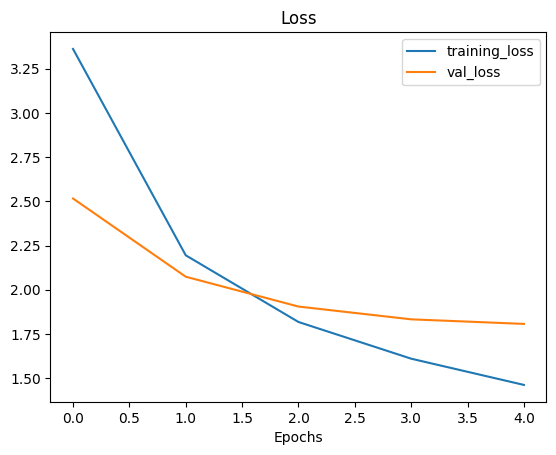

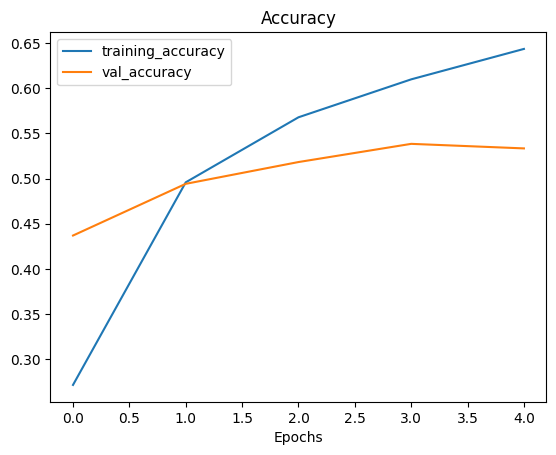

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> The deviation of test accuracy/loss curves from the training accuracy/loss curve hints that the model might be overfitting(performing too well on the training data but not being able to generalize well on unseen data)

## Fine-tuning the model

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile the model with lower learning rate (good practice to lower the learning rate when fine tuning)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ["accuracy"])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling True
output_layer True


In [ ]:
# Check which layers in the base model are trainable
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine tune for 5 more layers
fine_tune_epochs = 10 # model has already done 5 epochs(feature extraction), this is the total number of epochs (5 + 5)

# Fine tuning the model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 78s 293ms/step - loss: 1.2058 - accuracy: 0.6818 - val_loss: 1.7840 - val_accuracy: 0.5384
Epoch 6/10
237/237 [==============================] - 70s 293ms/step - loss: 1.0857 - accuracy: 0.7127 - val_loss: 1.7573 - val_accuracy: 0.5469
Epoch 7/10
237/237 [==============================] - 60s 251ms/step - loss: 1.0066 - accuracy: 0.7283 - val_loss: 1.7410 - val_accuracy: 0.5463
Epoch 8/10
237/237 [==============================] - 61s 254ms/step - loss: 0.9439 - accuracy: 0.7489 - val_loss: 1.7537 - val_accuracy: 0.5501
Epoch 9/10
237/237 [==============================] - 57s 239ms/step - loss: 0.8926 - accuracy: 0.7576 - val_loss: 1.7638 - val_accuracy: 0.5400
Epoch 10/10
237/237 [==============================] - 58s 241ms/step - loss: 0.8272 - accuracy: 0.7716 - val_loss: 1.7410 - val_accuracy: 0.5471


In [ ]:
# Evaluate on the entire test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 54s 68ms/step - loss: 1.4881 - accuracy: 0.6040


[1.488081693649292, 0.6040396094322205]

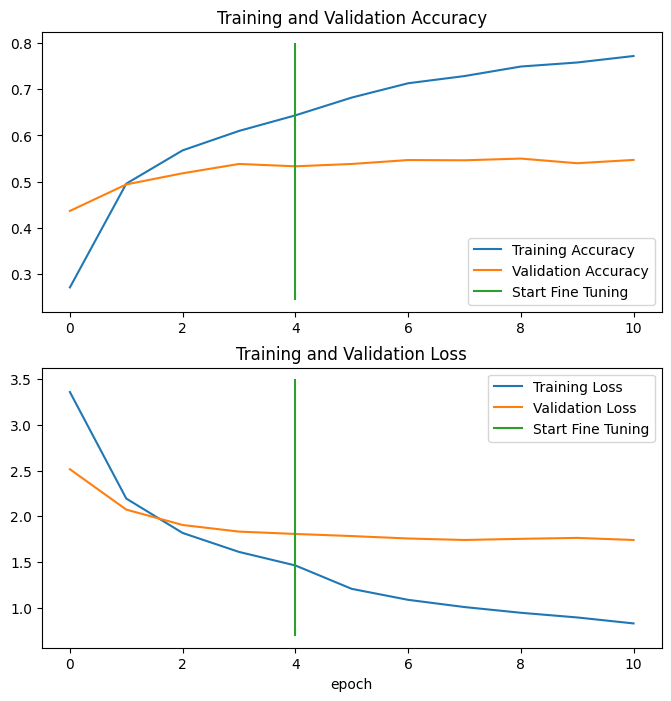

In [ ]:
# Compare the histories of featrure extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading the model
For the model to be used in an external application, the model needs to be saved and exported first.

In [ ]:
# Save the fine-tuned model
model.save("/content/drive/MyDrive/Food_Vision/101_food_classes_10_percent_saved_big_model")

In [ ]:
# Load and evaluate the saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Food_Vision/101_food_classes_10_percent_saved_big_model")

In [ ]:
# Evaluate loaded model to presaved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 62s 76ms/step - loss: 1.4881 - accuracy: 0.6040


[1.488081693649292, 0.6040396094322205]

In [ ]:
# Results from the loaded model should be very similar to the results from the presaved model
all_classes_10_percent_fine_tune_results

[1.488081693649292, 0.6040396094322205]

In [ ]:
loaded_model_results == all_classes_10_percent_fine_tune_results

True

## Evaluating the performance of the big model across all different classes

Making predictions, visualizing them and finding out which predictions were the "most" wrong

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-01-17 08:27:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   176MB/s    in 0.3s    

2024-01-17 08:27:22 (176 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model
results_downloaded_model = model.evaluate(test_data)

790/790 [==============================] - 59s 72ms/step - loss: 1.8027 - accuracy: 0.6078


In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

## Making predictions on the trained model

In [ ]:
# Make predictions
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 75s 88ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"\nPrediction probabilities for sample 0: {preds_probs[0]}\n")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")
print(f"Predicted class for sample 0: {test_data.class_names[preds_probs[0].argmax()]}")

Number of prediction probabilities for sample 0: 101

Prediction probabilities for sample 0: [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-05 1.28526

In [ ]:
# Pred class for each model
pred_classes = preds_probs.argmax(axis = 1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Comparing the model's predictions to the original test data labels, to evaluate the predictions

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating the model's predictions
One way to check whether the model's predictions array is in the same order as the test labels array is to find the accuracy score.

In [ ]:
# trying out sklearn's accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

NameError: name 'results_downloaded_model' is not defined

## Making a confusion matrix

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix_new(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Changed (plot x-ticks vertically)
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix_new(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100,100),
                      text_size = 20,
                      savefig = True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict = True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Plotting all classes' F1 score

In [ ]:
# Creating an empty dictionary
class_f1_scores = {}

for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add classnames and f1 scores to empty dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)

In [ ]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

In [ ]:
def auto_label(rectangles):
  for rect in rectangles:
    width = rect.get_width()
    ax.text(rect.get_x() + rect.get_width() / 2, (rect.get_y() + rect.get_height() / 2.)+0.4,
            '%.2f' % width,
             ha = 'center', va = 'bottom', color = 'white')

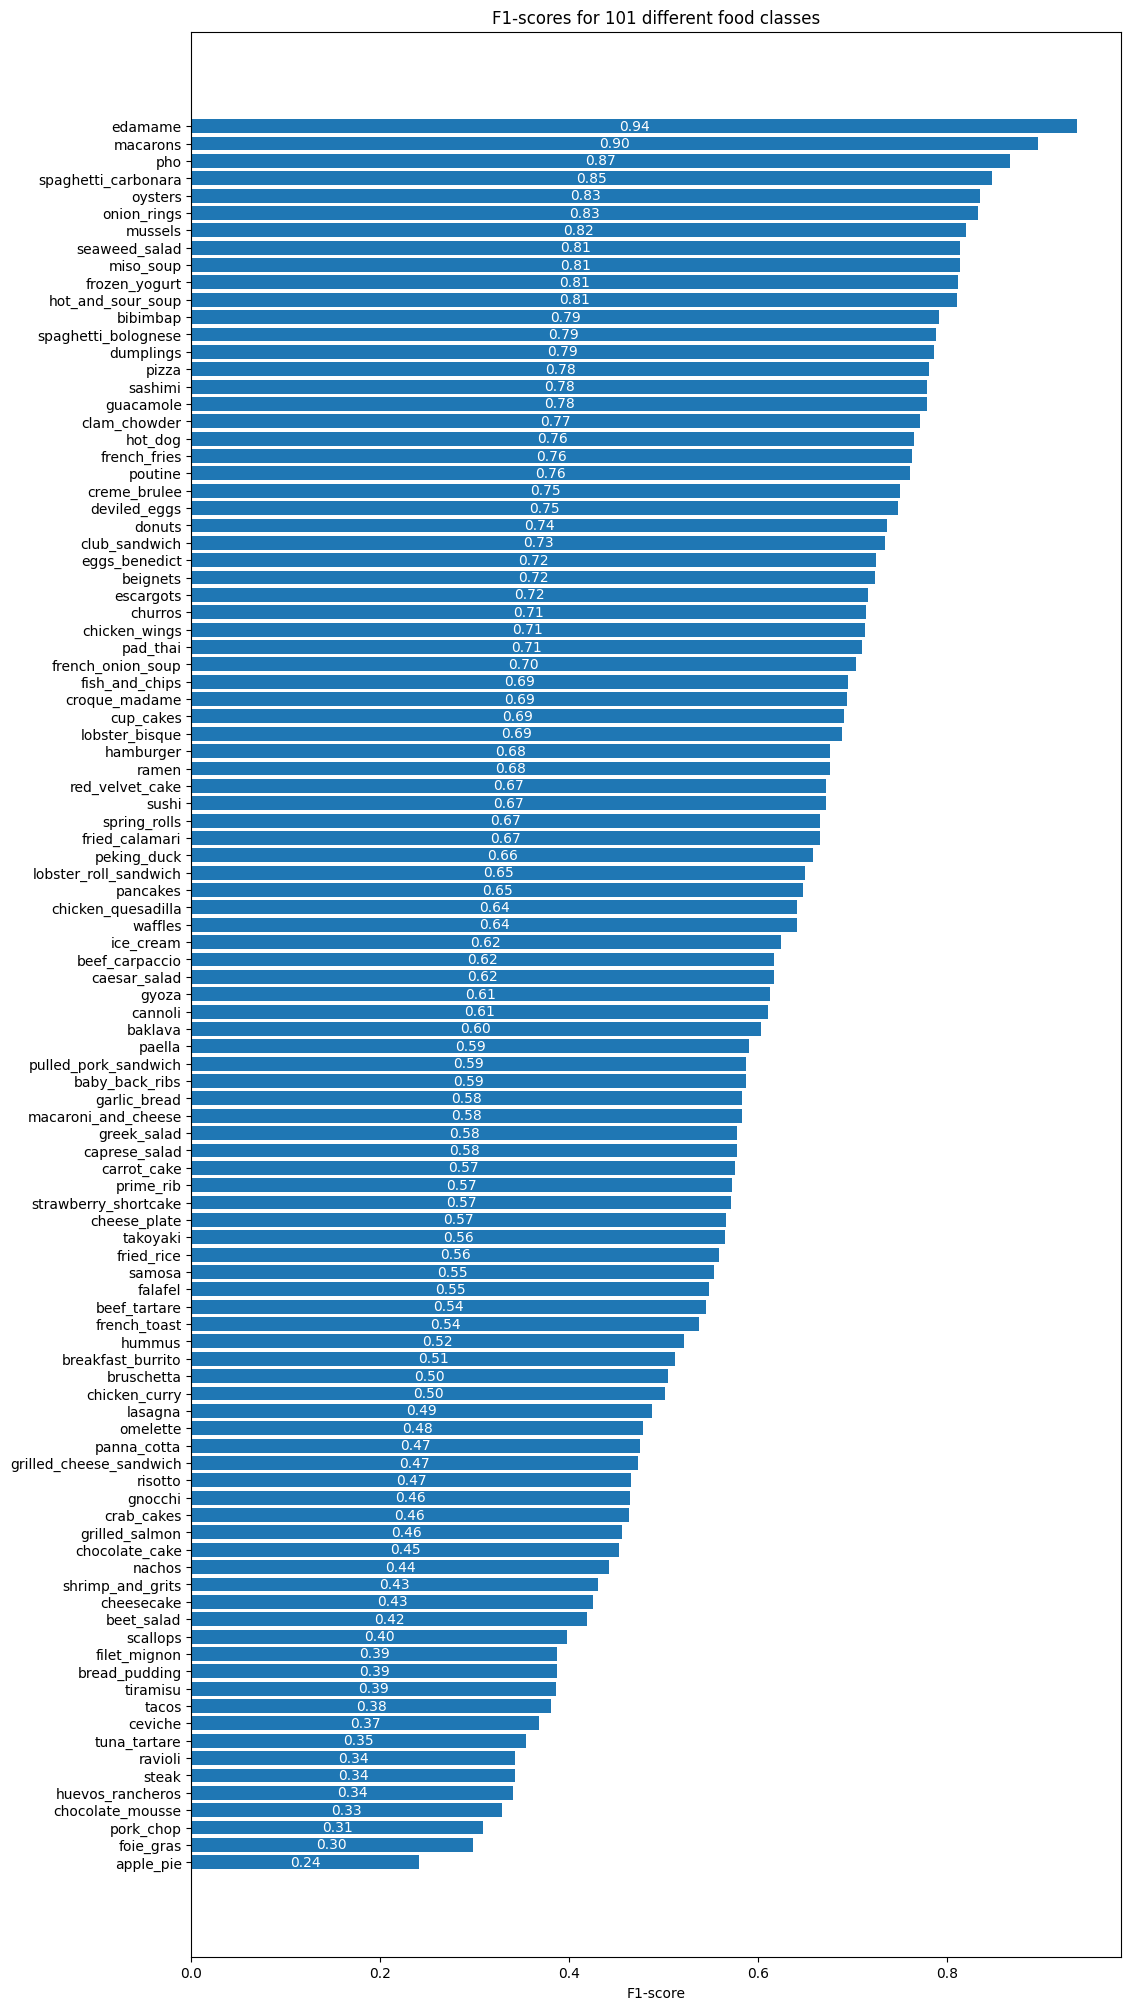

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes")
ax.invert_yaxis();

auto_label(ax.patches)

## Visualizing predictions on custom images
How does the model perform on food images not even in the test dataset.
To visualize the mdoel's predictions on custom images, a function is needed to load and preprocess images. Specific steps:
* Reading a target image filepath using tf.io.read_file().
* Turn the image into a tensor using tf.io.decode_image().
* Resize the image tensor to be the same size as the images the model has trained on using tf.image.resize().
* Scale the image to get all the pixel values between 0 & 1 (if necessary).

In [ ]:
# Create a function to load and prepare images
def load_and_prep_images(filename, img_shape = 224, scale = True):
  """
    Reads in an image from filename, turns it into a tensor and reshapes into specified shape(img_shape, img_shape, 3).
    Args:
      filename (str): path to target image
      image_shape (int): height/width dimension of target image size
      scale(bool): scale pixel values from 0-255 to 0-1 or not.

    Returns:
      Image tensor of shape (img_shape, img_shape, 3)
  """

  # Read the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels = 3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale?
  if scale:
    # Rescale the image (get it from 1-255 to 0-1)
    return img/255.
  else:
    return img

Now that there's a function to load and prepare the images... Creating a function to visualize images, their target label and the model's predictions.

Specifically, the function needs to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original images along with the model's predictions, prediction probabilities and truth label.

1/1 [==============================] - 0s 26ms/step


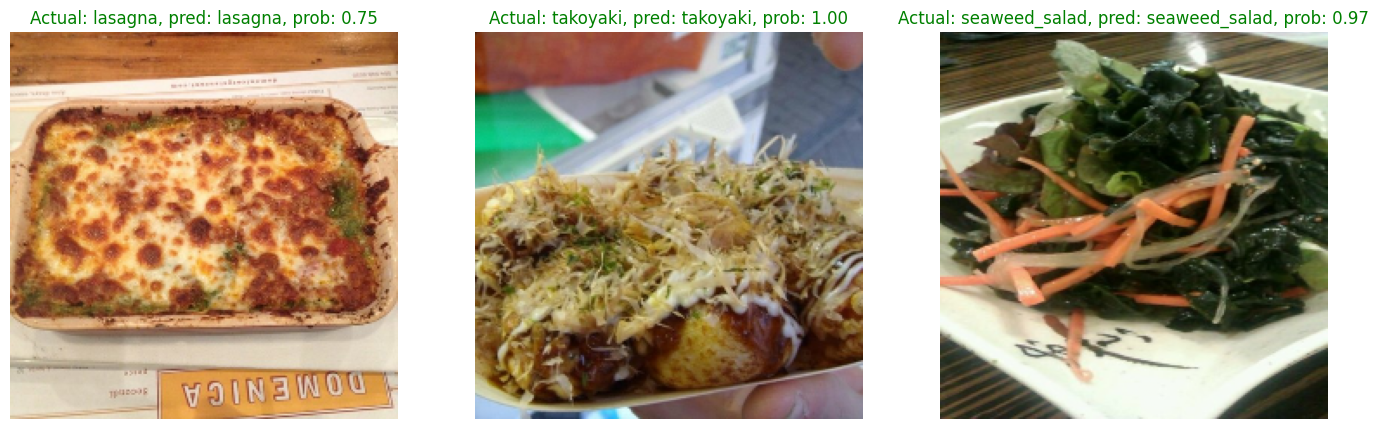

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" +  class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_images(filepath, scale = False)
  img_expanded = tf.expand_dims(img, axis= 0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]
  # print(pred_prob)
  # print(pred_class)

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_col = "green"
  else:
    title_col = "red"

  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_col)
  plt.axis(False);

## Finding the most wrong predictions
To find where the model is most wrong, the following needs to be investigated:
* Get all of the image file paths in the test dataset using list_files() method.
* Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our models), max prediction probabilities, prediction class names, ground truth class names.
* Use the DataFrame to find all of the wrong predictions.
* Sort the DataFrame on wrong predictions (have the highest prediction probability predictions at the top).
* Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle = False):
  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path" : filepaths,
                        "y_true" : y_labels,
                        "y_pred" : pred_classes,
                        "pred_conf" : preds_probs.max(axis = 1),
                        "y_true_classname" : [class_names[i] for i in y_labels],
                        "y_pred_classname" : [class_names[i] for i in pred_classes]})

In [ ]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in the DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False)
top_100_wrong.head()

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   

       pred_conf       y_true_classname y_pred_classname  pred_correct  
21810   0.999997               scallops        cup_cakes         False  
231     0.999995              apple_pie          waffles         False  
15359   0.999988  lobster_roll_sandwich        hamburger         False  
23539   0.999987   strawberry_shortcake  red_velvet_cake         False  
21400   0.999981                 samosa     spring_rolls         False

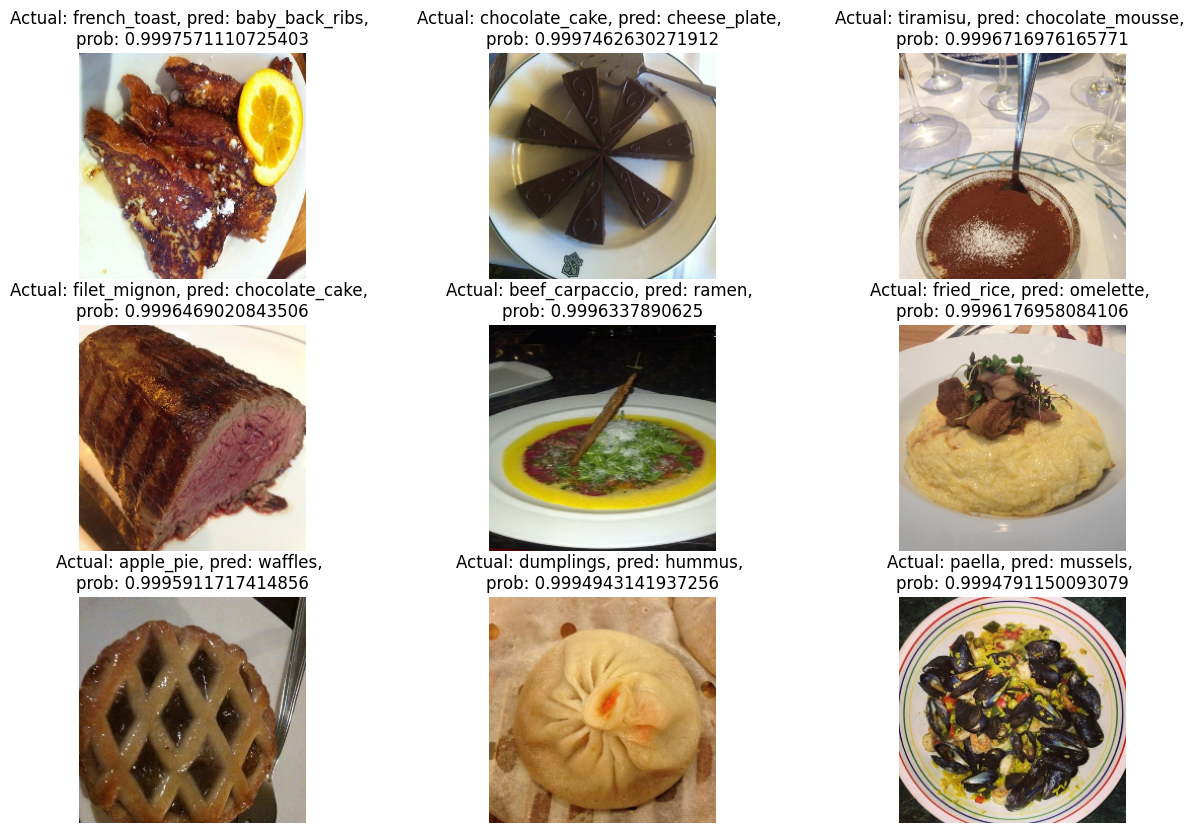

In [ ]:
# Make preds on a series of random images
images_to_view = 9
start_index = 20

plt.figure(figsize = (15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_images(row[1], scale = False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img/255.)
  plt.title(f"Actual: {y_true_classname}, pred: {y_pred_classname}, \nprob: {pred_prob}")
  plt.axis(False)

## Testing on custom images

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2024-01-17 10:05:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  49.9MB/s    in 0.3s    

2024-01-17 10:05:53 (49.9 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("/content/custom_food_images.zip")

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 26ms/step


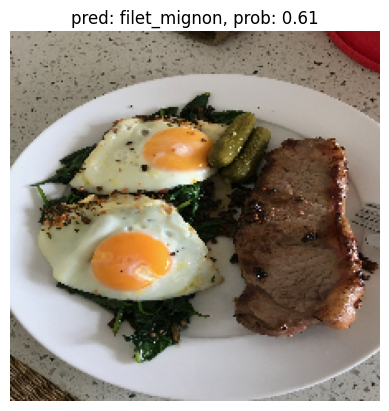

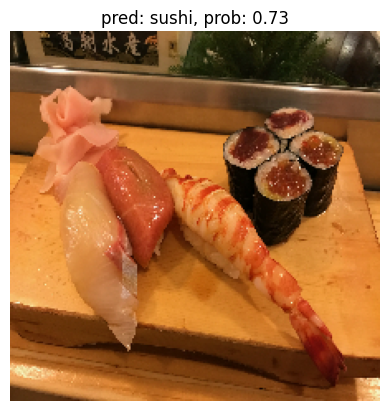

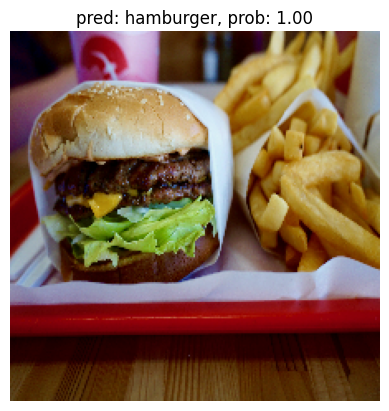

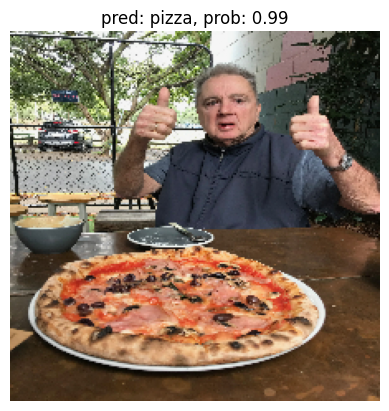

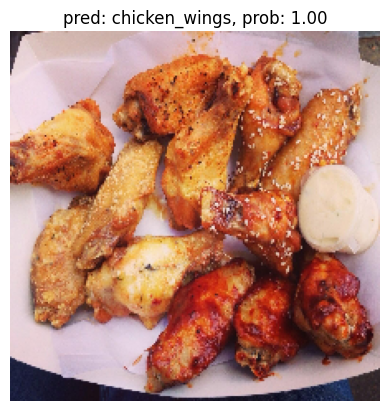

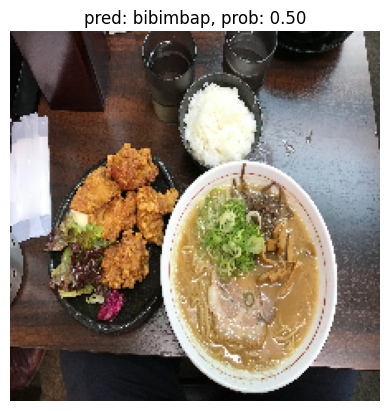

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_images(img, scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis = 0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False);